# HW 3: Unsupervised Learning Practice
## Guide created by Kate Moore, 2019

First, import the red wine csv file into a pandas dataframe from the following website: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ (Note: you need to adjust the argument for read_csv() from sep=',' to sep=';'). Use the wine quality data set to answer the following questions. Present any figures that assist you in your analysis.

## Data Set-Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
%matplotlib inline


# Remove the data conversion warning.
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Import Data
red_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
red_wine.head(6)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [2]:
# Check how many quality levels are in the data. Just out of curiosity. I'm exploring that data.
quality_levels = set(red_wine["quality"])
print(f"There are {len(quality_levels)} quality levels in the dataset: {quality_levels}")

There are 6 quality levels in the dataset: {3, 4, 5, 6, 7, 8}


In [3]:
# Scale the Data. Note: I'm using scale() instead of StandardScalar()
# Read more about the difference here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html
rw_scaled = pd.DataFrame(scale(red_wine), index=red_wine.index, columns=red_wine.columns)

In [4]:
# Check the now scaled quality levels
quality_levels = set(rw_scaled["quality"])
print("The new scaled quality levels: {}".format(sorted(quality_levels)))

The new scaled quality levels: [-3.265164632733176, -2.0264936368279924, -0.787822640922809, 0.4508483549823745, 1.6895193508875581, 2.9281903467927415]


**Note:** Our 'quality' levels look like this because we have standardized our data. Standardization shifts the distribution of each attribute so that it has a mean of zero and a standard deviation of one (unit variance). 
***Source:*** https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

**Why do we standardize?** Well, it's useful to standardize attributes for a model that relies on the distribution of attributes such as Gaussian processes, which we are for this assignment. A Gaussian process uses a measure of the similarity between points (the kernel function) to predict the value for an unseen point from training data. The prediction is not just an estimate for that point, but also has uncertainty information.
***Source:*** https://en.wikipedia.org/wiki/Gaussian_process

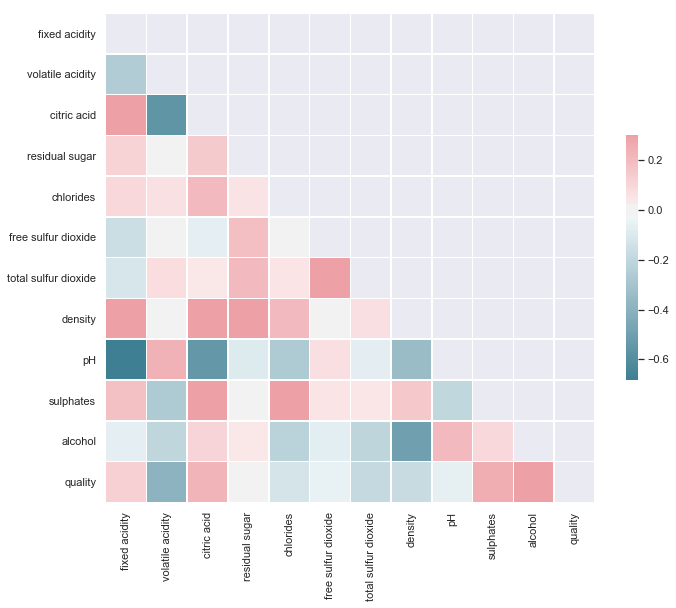

In [5]:
# Compute the correlation matrix
corr = red_wine.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Note:** Above is a correlation table that I've represented as a heat-map. It uses colors to show the positive and negative correlations between each of the scaled variables. It doesn't answer any questions for this assignment, but it does give a sense of (1) the relationships in the data and (2) what to expect in further analysis. In this case, it looks like we should expect 'alcohol' to have a positive relationship with quality and 'volitile acidity' to have a negative relationship with quality.

**Why are you doing all this extra stuff before answering the questions?** It's good practice to explore your data before you begin analysis. You want to have a basic understanding that can help you later in the analysis ...when you have to ask yourself, "Does this output make sense?"

# K-Means Clustering

### Question 1.

#### 1a. Use K Means Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.)

#### 1b. Describe variables that cluster with higher values of wine quality. Describe variables that cluster with lower values of wine quality.

#### 1c. If you want to make a good bottle of wine, then what characteristics are most important according to this analysis?

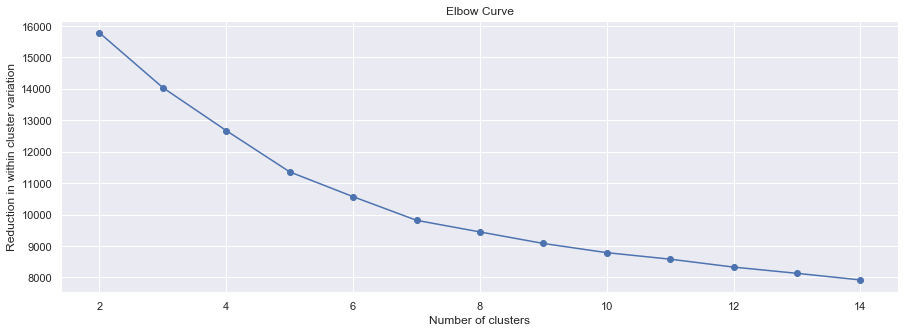

In [6]:
# Visualize all possible clusters and their effect on explained variance using an Elbow Curve graph
within_cluster_variance = [] 

for k in range(2, 15): 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rw_scaled)
    within_cluster_variance.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), within_cluster_variance, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')
plt.title('Elbow Curve');

**Note:** From the elbow chart above, we can not see a clear elbow, so I can not determine the optimal number of clusters. So, I examine the raw data using tables to look for meaningful relationships that appear when I use different numbers of clusters to organize the data.

In [7]:
# Compare Dataframes with Different Numbers of Clusters

# 2 Clusters
km2 = KMeans(n_clusters=2, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km2.labels_

# Check the amount of data in each cluster.
pd.Series(km2.labels_).value_counts()

0    1017
1     582
dtype: int64

**Note:** There are 1,017 values in Cluster 0 and 582 values in Cluster 1. The clusters aren't the same size. Cluster 0 is almost twice the size of Cluster 1. This means that Cluster 0 could "dominate" Cluster 1, essentially "dragging" the centroid from Cluster 0 closer to Cluster 1 simply because that is the best way for the algorithm to minimized the SSE. 
Here's a nice article that illustrates this problem well: http://varianceexplained.org/r/kmeans-free-lunch/

**Should clusters be the same size?** An assumption of kmeans clustering is that your clusters are roughly the same size. Of course, you can run kmeans with clusters of different sizes, but you risk incorrect output when you have clusters, like the ones we have here, that are ***very different*** in size. 

In [8]:
# Display mean values of each variable for each cluster.
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,-0.509265,0.418390,-0.570319,-0.073051,-0.133948,0.102514,0.142544,-0.224035,0.388743,-0.325572,-0.166682,-0.266533
1,0.889901,-0.731104,0.996589,0.127651,0.234064,-0.179136,-0.249085,0.391484,-0.679299,0.568912,0.291263,0.465746


**Note:** Below is my analysis. I list all variables with means above or below 0.5. I just decided that 0.5 was my threshold for accepting variables as indicators of association. You can choose whatever threshold you like. The trick is to be consistent. Use the same threshold for all comparisons.

**1a. & 1b Answer:** If we use 2 kmeans clusters, then the following variables cluster with High and Low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **fixed acidity, citric acid, sulphates**

* Variables with a strong inverse relationship with High Quality Wine:  **volatile acidity, pH**

* Variables with a strong positive relationship with Low Quality Wine: 

* Variables with a strong inverse relationship with Low Quality Wine: **fixed acitidy, citric acid**

**Note:** Notice that 'fixed acidity' and 'citric acid' are indicators for both High Quality wine and Low Quality wine. That's not very helpful for us. We need to be able to distinguish between these two types of wine. So, kmeans=2 clusters is not a good answer.

In [9]:
# 3 Clusters
km3 = KMeans(n_clusters=3, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km3.labels_

# Check the amount of data in each cluster.
pd.Series(km3.labels_).value_counts()

1    716
0    513
2    370
dtype: int64

**Note:** There are 716 values in Cluster 1, 513 values in Cluster 0, and 370 values in Cluster 2. These are much more evenly distributed than the clusters we created with kmeans=2. Already, 3 clusters are looking better than 2.

In [10]:
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,0.930029,-0.749894,1.019797,0.032490,0.235600,-0.399642,-0.439891,0.346228,-0.707429,0.598409,0.384940,0.561918
1,-0.627859,0.497832,-0.777490,-0.229822,-0.169170,-0.256967,-0.362272,-0.411384,0.595469,-0.312082,0.017232,-0.170217
2,-0.074481,0.076345,0.090613,0.399689,0.000711,1.051364,1.310948,0.316044,-0.171471,-0.225766,-0.567061,-0.449699


**Note:** My threshold = 0.5. Also, Now, I don't need to look at all the clusters, just the clusters with the highest and lowest values for 'quality'. This means that I'm only interested in Cluster 0 ('quality'=0.56) and Cluster 2 ('quality'=-0.45), which represent my high quality and low quality wines respectively.

**1a. & 1b Answer:** If we use 3 kmeans clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **fixed acidity, citric acid, chlorides, sulphates**

* Variables with a strong inverse relationship with High Quality Wine:  **volatile acidity, pH**

* Variables with a strong positive relationship with Low Quality Wine: **free sulfur dioxide, total sulfur dioxide**

* Variables with a strong inverse relationship with Low Quality Wine: **alchohol**

**Note:** With more clusters, we are able to see clearer relationships among the variables. For example, now we can distinguish between variables that are associated with high and low wine quality. In other words, there is now 'overlap' where variables appear to be indicators of both high and low wine quality, which we observed with kmeans=2. However, our Elbow Chart (above) shows us that kmeans=3 does not explain a great deal of variance in our data. So, kmeans=3 is not a good answer.

In [11]:
# 4 Clusters
km4 = KMeans(n_clusters=4, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km4.labels_

# Check the amount of data in each cluster.
pd.Series(km4.labels_).value_counts()

1    716
2    486
3    369
0     28
dtype: int64

**Note:** Cluster 0 is much smaller than the other three. This may distort its centroid, essentially forcing it to be less reprsentative of its small cluster. Here's a nice article that illustrates this problem well: http://varianceexplained.org/r/kmeans-free-lunch/

In [12]:
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,0.095416,0.002200,1.181553,-0.389872,5.784760,-0.049516,0.510330,0.180072,-1.735792,3.663412,-0.869731,-0.345440
1,-0.627859,0.497832,-0.777490,-0.229822,-0.169170,-0.256967,-0.362272,-0.411384,0.595469,-0.312082,0.017232,-0.170217
2,0.976887,-0.790737,1.010694,0.055971,-0.076607,-0.417590,-0.489756,0.355582,-0.649275,0.424987,0.454265,0.611417
3,-0.075586,0.075307,0.087811,0.401808,-0.009801,1.052367,1.309265,0.316249,-0.168580,-0.232165,-0.565741,-0.448783


**Note:** My threshold = 0.5. Cluster 2 ('quality'=0.62) = high quality. Cluster 3 ('quality'=-0.45) = low quality.


**1a. & 1b Answer:** If we use 4 kmeans clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **fixed acidity, citric acid**

* Variables with a strong inverse relationship with High Quality Wine:  **volatile acidity, pH**

* Variables with a strong positive relationship with Low Quality Wine: **free sulfur dioxide, total sulfur dioxide**

* Variables with a strong inverse relationship with Low Quality Wine: **alcohol**

**Note:** Our answers for kmeans=4 are pretty similar to our previous answers for kmeans=3. The difference is that kmeans=4 has fewer indicators. This is a good. We're seeing a pattern and we're starting to narrow it down. However, because our clusters are not even close to the same size, these relationships might be incorrect. So, kmeans=4 is not a good answer.


In [13]:
# 5 Clusters
km5 = KMeans(n_clusters=5, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km5.labels_

# Check the amount of data in each cluster.
pd.Series(km5.labels_).value_counts()

1    525
4    367
0    365
2    314
3     28
dtype: int64

**Note:** Cluster 3 is much smaller than the other four clusters. As discussed above, this could be a problem for our analysis.

In [14]:
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,1.326193,-0.699450,1.138910,0.146728,-0.010382,-0.533527,-0.532261,0.762090,-0.839046,0.369691,0.209280,0.444061
1,-0.489620,0.664517,-0.814097,-0.231659,-0.077442,-0.416556,-0.422053,-0.097943,0.425109,-0.420714,-0.426842,-0.455151
2,-0.654610,-0.406543,-0.171653,-0.228061,-0.390926,0.123734,-0.243842,-1.164709,0.601303,0.183829,1.250916,0.809826
3,0.095416,0.002200,1.181553,-0.389872,5.784760,-0.049516,0.510330,0.180072,-1.735792,3.663412,-0.869731,-0.345440
4,-0.065761,0.092700,0.088596,0.410334,0.014234,1.024423,1.302806,0.364942,-0.155689,-0.202616,-0.601445,-0.457060


**Note:** My threshold = 0.5. Cluster 2 ('quality'=0.81) = high quality. Cluster 4 ('quality'=-0.46) = low quality.


**1a. & 1b Answer:** If we use 5 kmeans clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **pH, alcohol**

* Variables with a strong inverse relationship with High Quality Wine:  **fixed acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **free sulfer dioxide, total sulfur dioxide**

* Variables with a strong inverse relationship with Low Quality Wine: **alcohol**

**Note:** Our answers for kmeans=5 are noteably different from kmeans=4. Notice that alcohol is now a negative indicator of low quality and also an indicator of high quality, which kind of makes sense. Also notice that volitile acidity is now no longer on the list. This is surprising because our exporation of the data (e.g. correlation matrix heat map, above) lead us to believe that volitile acidity would play an important role in distinguishing between high and low quality. 

This leads me to an important point in deciding on kmeans # of clusters. Notice that the values of 'quality' for Cluster 1 and Cluster 4 are really similar: -0.455, -0.457 respectively. We identified Cluster 4 as our cluster with the best association to low quality (which is true), but Cluster 1 has an almost identical association *and*, look at the mean value for 'volitile acidity', it's 0.7. That's within our threshold! So, because Cluster 1 and Cluster 4 are so close in terms of their association with low quality, it's hard to distinguish between the variables. Because these are variables that we think should be indicators, kmeans=5 is not a good answer.

In [15]:
# 6 Clusters
km6 = KMeans(n_clusters=6, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km6.labels_

# Check the amount of data in each cluster.
pd.Series(km6.labels_).value_counts()

2    525
1    364
0    338
4    314
5     30
3     28
dtype: int64

**Note:** Yikes. Now Cluster 5 and Cluster 3 are much smaller than the other clusters, particularly Cluster 2. As discussed above, this could be a problem for our analysis.

In [16]:
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,-0.048508,0.090766,0.075206,0.017388,-0.016707,0.942947,1.243159,0.295714,-0.148300,-0.209240,-0.608429,-0.479987
1,1.326237,-0.697568,1.140359,0.121868,-0.009332,-0.532398,-0.531762,0.755661,-0.837949,0.370677,0.213009,0.447445
2,-0.489620,0.664517,-0.814097,-0.231659,-0.077442,-0.416556,-0.422053,-0.097943,0.425109,-0.420714,-0.426842,-0.455151
3,0.095416,0.002200,1.181553,-0.389872,5.784760,-0.049516,0.510330,0.180072,-1.735792,3.663412,-0.869731,-0.345440
4,-0.654610,-0.406543,-0.171653,-0.228061,-0.390926,0.123734,-0.243842,-1.164709,0.601303,0.183829,1.250916,0.809826
5,-0.214283,0.065247,0.256878,5.130373,0.349272,1.876761,1.907622,1.236162,-0.275023,-0.120872,-0.540972,-0.209776


**Note:** My threshold = 0.5. Cluster 4 ('quality'=0.81) = high quality. Cluster 0 ('quality'=-0.47) = low quality.

**1a. & 1b Answer:** If we use 6 kmeans clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **pH, alcohol**

* Variables with a strong inverse relationship with High Quality Wine:  **fixed acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **free sulfur dioxide, total sulfur dioxide**

* Variables with a strong inverse relationship with Low Quality Wine: **alcohol**

**Note:** Our answers to kmeans=6 are very similar to our previous answers for kmeans=5. Notice that we have a similar problem to the one described above for kmeans=5. Notice that the mean value for 'quality' in Cluster 3 = -0.46, which is very similar to the value for 'quality' in Cluster 0 ('quality'=-0.47), which we identified as our cluster with the best association to low quality wine. For all these reasons, kmeans=6 is not a good answer.

In [17]:
# 7 Clusters
km7 = KMeans(n_clusters=7, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km7.labels_

# Check the amount of data in each cluster.
pd.Series(km7.labels_).value_counts()

0    520
1    362
5    340
3    182
2    137
4     30
6     28
dtype: int64

**Note:** We still have two relatively small clusters: Cluster 4 and Cluster 6. As discussed above, this could be a problem for our analysis.

In [18]:
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,-0.479525,0.658327,-0.809731,-0.228982,-0.070489,-0.423618,-0.426617,-0.084316,0.406713,-0.420212,-0.438501,-0.449570
1,1.338864,-0.694390,1.141864,0.127985,-0.010033,-0.538312,-0.537394,0.758889,-0.847729,0.364840,0.213527,0.444005
2,-1.154053,0.354500,-0.957430,-0.236750,-0.458571,0.358187,-0.081480,-1.433378,1.350598,-0.047658,1.454380,0.541262
3,-0.302967,-0.932307,0.389712,-0.229265,-0.351260,-0.047414,-0.357913,-0.972096,0.084992,0.340036,1.084977,0.961290
4,-0.214283,0.065247,0.256878,5.130373,0.349272,1.876761,1.907622,1.236162,-0.275023,-0.120872,-0.540972,-0.209776
5,-0.053865,0.082746,0.079869,0.011490,-0.015917,0.940564,1.238714,0.294982,-0.141944,-0.199614,-0.604149,-0.470869
6,0.095416,0.002200,1.181553,-0.389872,5.784760,-0.049516,0.510330,0.180072,-1.735792,3.663412,-0.869731,-0.345440


**Note:** My threshold = 0.5. Cluster 3 ('quality'=0.96) = high quality. Cluster 5 ('quality'=-0.47) = low quality.

**1a. & 1b Answer:** If we use 7 kmeans clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **alcohol**

* Variables with a strong inverse relationship with High Quality Wine:  **volatile acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **free sulfer dioxide, total sulfur dioxide**

* Variables with a strong inverse relationship with Low Quality Wine: **alcohol**

**Note:** We got volatile acidity back! Our data exploration led us to expect 'volitile acidity' would be an negative indicator of wine quality, so it's a good sign that we are seeing it appear again in our list (See above Notes for more on why this is useful turn of events). Also, notice that mean value of 'quality' that is closest to that of Cluster 3 (i.e. the cluster we decided had the best association with low quality wine) is -0.45, Cluster 0, which is still close to our lowest 'quality' value (-0.47), but the difference between these two values is greater than the difference we had for kmeans=6. For all these reasons, kmeans=7 is a good answer.

In [19]:
# 8 Clusters
km8 = KMeans(n_clusters=8, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km8.labels_

# Check the amount of data in each cluster.
pd.Series(km8.labels_).value_counts()

3    519
5    340
1    197
0    182
4    166
6    137
2     30
7     28
dtype: int64

**Note:** We still have two relatively small clusters: Cluster 2 and Cluster 7. As discussed above, this could be a problem for our analysis.

In [20]:
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,-0.302967,-0.932307,0.389712,-0.229265,-0.351260,-0.047414,-0.357913,-0.972096,0.084992,0.340036,1.084977,0.961290
1,0.783145,-0.879959,0.969606,0.061423,-0.051560,-0.618619,-0.662384,0.202493,-0.520293,0.424016,0.500176,0.714930
2,-0.214283,0.065247,0.256878,5.130373,0.349272,1.876761,1.907622,1.236162,-0.275023,-0.120872,-0.540972,-0.209776
3,-0.480537,0.662155,-0.812568,-0.228277,-0.069787,-0.422984,-0.425889,-0.083747,0.406512,-0.420360,-0.439485,-0.448918
4,1.990576,-0.477987,1.343404,0.202621,0.036689,-0.444301,-0.390673,1.412331,-1.228127,0.290348,-0.127504,0.115064
5,-0.053865,0.082746,0.079869,0.011490,-0.015917,0.940564,1.238714,0.294982,-0.141944,-0.199614,-0.604149,-0.470869
6,-1.154053,0.354500,-0.957430,-0.236750,-0.458571,0.358187,-0.081480,-1.433378,1.350598,-0.047658,1.454380,0.541262
7,0.095416,0.002200,1.181553,-0.389872,5.784760,-0.049516,0.510330,0.180072,-1.735792,3.663412,-0.869731,-0.345440


**Note:** My threshold = 0.5. Cluster 0 ('quality'=0.96) = high quality. Cluster 5 ('quality'=-0.47) = low quality.

**1a. & 1b Answer:** If we use 8 kmeans clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **volatile acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **free sulfur dioxide, total sulfer dioxide**

* Variables with a strong inverse relationship with Low Quality Wine: **alcohol**

**Note:** Answers for kmeans=8 are similar to the previous answers for kmeans=7. For all the reasons as to why kmeans=7 is a good answer, kmeans=8 is also a good answer.

In [21]:
# 9 Clusters
km9 = KMeans(n_clusters=9, n_init=20).fit(rw_scaled)
rw_scaled['cluster'] = km9.labels_

# Check the amount of data in each cluster.
pd.Series(km9.labels_).value_counts()

2    335
5    274
0    250
1    192
7    185
4    165
8    138
3     32
6     28
dtype: int64

**Note:** We still have two relatively small clusters: Cluster 3 and Cluster 6. Now, the largest cluster, Cluster 2, much closer in size to the other clusters than in our previous models. As discussed above, this could be a problem for our analysis, but this is a far better situation for analysis than perviously.

In [22]:
display(rw_scaled.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,-0.646943,1.157627,-1.066732,-0.104581,-0.084389,-0.301516,-0.386309,-0.058280,0.893666,-0.418927,-0.270197,-0.698638
1,0.782587,-0.877878,0.971184,0.021614,-0.047553,-0.650481,-0.676887,0.210177,-0.507669,0.421864,0.490296,0.689551
2,-0.066334,0.084133,0.075618,0.009107,-0.016450,0.936440,1.237444,0.283221,-0.140280,-0.201171,-0.604578,-0.466138
3,-0.165687,-0.006155,0.293465,5.094012,0.332801,1.727338,1.745694,1.226920,-0.288656,-0.096037,-0.479176,-0.129779
4,2.014547,-0.504827,1.361224,0.218206,0.056035,-0.405916,-0.343379,1.442691,-1.228458,0.321726,-0.130422,0.113029
5,-0.307983,0.211984,-0.561057,-0.340582,-0.063438,-0.536345,-0.464700,-0.090335,-0.054034,-0.430166,-0.595568,-0.227256
6,0.095416,0.002200,1.181553,-0.389872,5.784760,-0.049516,0.510330,0.180072,-1.735792,3.663412,-0.869731,-0.345440
7,-0.282398,-0.931486,0.398855,-0.231746,-0.352043,-0.024740,-0.347573,-0.970600,0.061783,0.345225,1.086314,0.979794
8,-1.155347,0.352424,-0.958342,-0.238833,-0.461018,0.370923,-0.071517,-1.439839,1.340289,-0.054076,1.444705,0.540607


**Note:** My threshold = 0.5. Cluster 7 ('quality'=0.97) = high quality. Cluster 0 ('quality'=-0.70) = low quality.

**1a. & 1b Answer:** If we use 9 kmeans clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **volitile acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **volitile acidity, pH**

* Variables with a strong inverse relationship with Low Quality Wine: **fixed acidity, citric acid**

**Notes:** The answers for kmeans=9 are notably different from previous answers with kmeans=8. Both 'free sulfur dioxide' and 'total sulfer dioxide' -- which have been consistent indicators of low quality for all previous models -- are no longer listed. This is might be a sign that our model is drawing inaccurate distinctions, and may be the result of having too many clusters. 

There are few other things happening in this model, which are less worthy of note. 'Volitile acidity' is now showing both an inverse relationship with high quality and a positive relationship with low quality, which makes sense. 

Also, 'PH' is showing very different relationships with quality in each of my models. With kmeans=4 it was an inverse indicator of high quality, but with kmeans=5, kmeans=6 and kmeans=7 it was a positive indicator of high quality. So, I am hesitant to report 'pH' as an indicator, regardless of the model I choose. 

## Visualizing Kmeans clustering with prediction

**Note:** Below, I use the kmeans attribute **predict()**, which assigns each data point to the closest cluster center. I use this method to color the data so you can see that values of 'volitile acidity' and 'alcohol' are assigned to different clusters.

Notice that I'm just plotting two variables, 'volitile acidity' and 'alcohol'. I'm not plotting all the variables. So this is not perfectly representing what is happening in kmeans clustering, which generates clusters (like those visualized here) with consideration of all the data values.

Text(0, 0.5, 'alcohol')

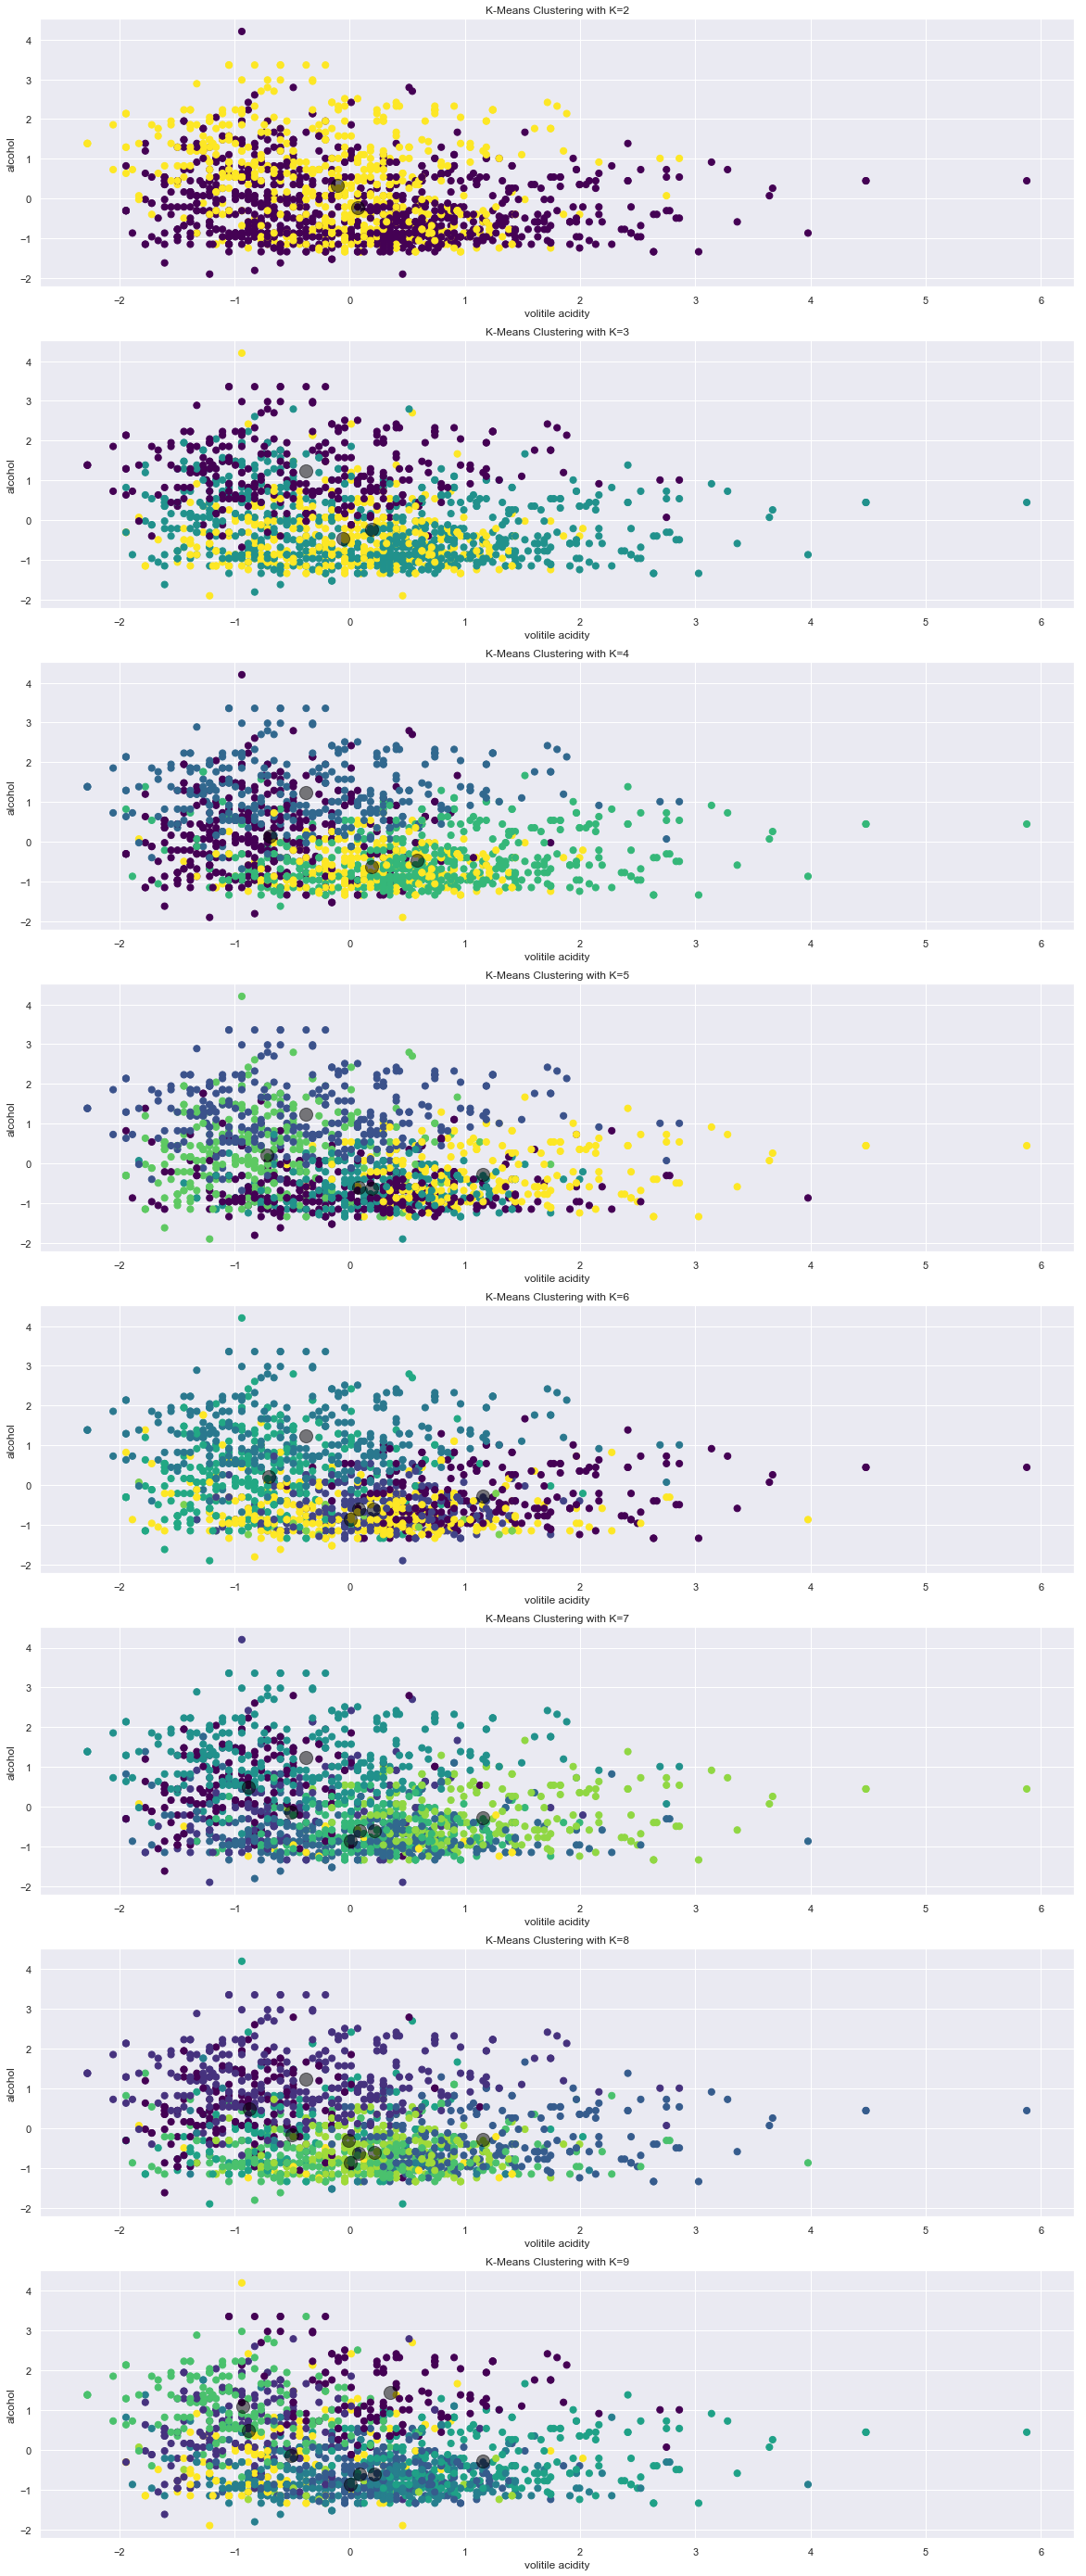

In [23]:
fig, (ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(8,1, figsize=(20,50))

# kmeans = 2
kmeans = KMeans(n_clusters = 2).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax2.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax2.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax2.set_title('K-Means Clustering with K=2')
ax2.set_xlabel('volitile acidity')
ax2.set_ylabel('alcohol')

# kmeans = 3
kmeans = KMeans(n_clusters = 3).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax3.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax3.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax3.set_title('K-Means Clustering with K=3')
ax3.set_xlabel('volitile acidity')
ax3.set_ylabel('alcohol')

# kmeans = 4
kmeans = KMeans(n_clusters = 4).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax4.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax4.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax4.set_title('K-Means Clustering with K=4')
ax4.set_xlabel('volitile acidity')
ax4.set_ylabel('alcohol')

# kmeans = 5
kmeans = KMeans(n_clusters = 5).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax5.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax5.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax5.set_title('K-Means Clustering with K=5')
ax5.set_xlabel('volitile acidity')
ax5.set_ylabel('alcohol')

# kmeans = 6
kmeans = KMeans(n_clusters = 6).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax6.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax6.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax6.set_title('K-Means Clustering with K=6')
ax6.set_xlabel('volitile acidity')
ax6.set_ylabel('alcohol')

# kmeans = 7
kmeans = KMeans(n_clusters = 7).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax7.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax7.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax7.set_title('K-Means Clustering with K=7')
ax7.set_xlabel('volitile acidity')
ax7.set_ylabel('alcohol')

# kmeans = 8
kmeans = KMeans(n_clusters = 8).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax8.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax8.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax8.set_title('K-Means Clustering with K=8')
ax8.set_xlabel('volitile acidity')
ax8.set_ylabel('alcohol')

# kmeans = 9
kmeans = KMeans(n_clusters = 8).fit(rw_scaled)
y_kmeans = kmeans.predict(rw_scaled)
ax9.scatter(rw_scaled.values[:,1], rw_scaled.values[:,10], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_ 
ax9.scatter(centers[:, 1], centers[:, 10], c='black', s=200, alpha=0.5)
ax9.set_title('K-Means Clustering with K=9')
ax9.set_xlabel('volitile acidity')
ax9.set_ylabel('alcohol')

**Note:** Notice that all cases the number of clusters matches the number of centroids. This is the effect of the way *predict()* identifies clusters. It's a bottom-up method. Essentially, you tell the algorithm how many clusters you want and then it assigns a color to each data value based on 'proximity'. It clusters similar values together.

Ultimately, kmeans = 7 or kmeans = 8 are the best answers for these data because...
1. They produce expected results (see correlation matric heat map).
2. The clusters they produce are not remarkably uneven in size (i.e. in the among of data assigned to each cluster).
2. They offer clear distinctions between the strongest indicators of high and low quality.
    
**1c. Answer:** Therefore, using 7 or 8 clusters with kmeans analysis, I conclude that if you want to make a good bottle of wine then you would want to include high levels of alchohol and low levels of  volitile acidity.

# Agglomerative Hierarchical Clustering

### Question 2:


#### 2a. Use Hierarchical Cluster Analysis to identify cluster(s) of observations that have high and low values of the wine quality. (Assume all variables are continuous.) Use complete linkage and the same number of groups that you found to be the most meaningful in question 1.

#### 2b. Describe variables that cluster with higher values of wine quality. Describe variables that cluster with lower values of wine quality.

#### 2c. If you want to make a good bottle of wine, then what characteristics are most important according to this analysis? Have your conclusions changed using Hierarchical clustering rather than k means clustering? Present any figures that assist you in your analysis.

## Hierarchical Clustering using a Distance Matrix

**Note:** Here, I create the Distance Matrix. The squareform method from scipy creates an adjacency matrix and pdist applies euclidean distance to each combo of observations

In [24]:
row_dist = pd.DataFrame(squareform(pdist(rw_scaled, metric='euclidean')), columns=red_wine.index, index=red_wine.index)
row_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598
0,0.000000,3.645063,2.036272,6.506826,0.000000,0.353963,5.388084,5.991897,5.759356,5.129468,...,5.893297,9.139354,8.766729,8.696426,2.806927,2.961242,9.004636,8.696426,2.893352,8.273993
1,3.645063,0.000000,2.411985,5.548929,3.645063,3.615689,3.961469,5.066220,4.955491,4.280871,...,4.361176,7.186879,7.602715,6.918557,3.531774,3.609136,7.219761,6.918557,3.881843,6.986571
2,2.036272,2.411985,0.000000,6.068196,2.036272,2.026811,5.280908,6.089012,5.884572,4.495501,...,5.372401,8.822591,9.006770,8.583019,2.620914,2.797399,8.936658,8.583019,3.105273,8.171282
3,6.506826,5.548929,6.068196,0.000000,6.506826,6.395824,4.266191,5.268423,4.608454,5.174952,...,6.276826,6.673014,7.678362,6.226364,6.260720,6.642332,6.955267,6.226364,6.924828,5.043987
4,0.000000,3.645063,2.036272,6.506826,0.000000,0.353963,5.388084,5.991897,5.759356,5.129468,...,5.893297,9.139354,8.766729,8.696426,2.806927,2.961242,9.004636,8.696426,2.893352,8.273993


**Note:** This is just to show you the distance matrix. It's not useful to look at all the values splayed out like this. Instead, we want to using complete linkage to form clusters and then display the mean of each value in each cluster (see below).

## Classify Categories using Complete Linkage

In [25]:
row_clusters = linkage(rw_scaled.values, method='complete', metric='euclidean')
k=7 # Here, I define number of clusters. I chose kmeans=7 from Question 1, so that's what I use here.
rw_scaled['cluster'] = fcluster(row_clusters, k, criterion='maxclust')
rw_scaled.groupby('cluster').mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
1,0.074897,-0.350945,3.127368,0.043416,11.116408,0.394484,0.320274,0.770280,-2.663717,5.735193,-0.960246,-1.407158
2,-0.238966,-0.057138,0.143336,5.427565,0.383672,1.751025,1.259573,1.299508,-0.177594,-0.249170,-0.581301,-0.191425
3,-0.647580,1.146473,-1.069162,-0.104509,-0.085270,-0.289861,-0.364830,-0.053211,0.900142,-0.421294,-0.274669,-0.689904
4,0.403777,-0.166311,0.298948,-0.041922,-0.018760,-0.035353,0.085481,0.375114,-0.374711,-0.077348,-0.305192,-0.067212
5,0.021548,0.043300,0.798992,-0.301187,3.969996,0.036552,0.755556,0.232997,-1.458571,3.531476,-0.775194,-0.363135
6,-0.539850,-1.512932,0.816598,0.320113,-0.826059,2.130183,3.172635,-2.565626,-1.374340,-1.027706,1.301955,1.070184
7,-0.661694,-0.363330,-0.191680,-0.229108,-0.389341,0.114509,-0.258071,-1.143153,0.643568,0.195943,1.233876,0.781940


**Note:** My threshold = 0.5. Cluster 6 ('quality'=1.07) = high quality. Cluster 0 ('quality'=-1.41) = low quality.

**2a. & 2b. Answer:** If we use complete linkage to generate 7 clusters, then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **citric acid, free sulfur dioxide, total sulfur dioxide, density, alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **fixed acidity, volatile acidity, chlorides, pH, sulphates**

* Variables with a strong positive relationship with Low Quality Wine: **citric acid, chlorides, density, sulphates**

* Variables with a strong inverse relationship with Low Quality Wine: **pH, alcohol**

**Note:** These results are very different from our kmeans analysis. Also notice that there is a lot of overlap / ambiguity. For example, 'citric acid' is a positive indicator of both high and low quality wine. This doesn't make a useful indicator at all.

If I had to use this method with 7 clusters, then I would adjust my threshold from 0.5 to a higher value to exclude more variables and select  the variables with the higher mean value for each cluster. I'll try raising my threshold to 1.0

**2a. & 2b. Answer:** My threshold = 1.0. Cluster 6 ('quality'=1.07) = high quality. Cluster 0 ('quality'=-1.41) = low quality. 

* Variables with a strong positive relationship with High Quality Wine: **free sulfur dioxide, total sulfur dioxide, sulphates, alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **volatile acidity, density, pH, sulphates**

* Variables with a strong positive relationship with Low Quality Wine: **citric acid, chlorides, sulphates**

* Variables with a strong inverse relationship with Low Quality Wine: **pH**

**Note:** These results are still very different from our kmeans analysis. Notice that there is still some overlap / ambiguity. For example, 'sulphates' and 'pH' are each indicators of both high and low quality wine. This doesn't make a useful indicator at all. I'll remove them both from the list.

**2a. & 2b. Answer:** My threshold = 1.0. Cluster 6 ('quality'=1.07) = high quality. Cluster 0 ('quality'=-1.41) = low quality. 

* Variables with a strong positive relationship with High Quality Wine: **free sulfur dioxide, total sulfur dioxide, sulphates, alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **volatile acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **citric acid, chlorides**

* Variables with a strong inverse relationship with Low Quality Wine:

**Note:** These results are still very different from our kmeans analysis. Notice that 'free sulfer dioxide' and 'total sulfur dioxide' were inverse indicators of high quality in the kmeans analysis, now they are positive indicators of quality. 

**2c. Answer:** Therefore, using k=7 with complete linkage analysis, I conclude that if you want to make a good bottle of wine then you would want to include high levels of 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', and of course 'alcohol'. You would want to make sure you have low levels of 'citric acid' and 'chlorides', which kimd of makes sense since these chemicals taste disguisting.

Whatever k you setted on using, you should have found that kmeans and complete linkage cluster analysis produce very different results. That's because... 

* kmeans forms clusters by minimizing the within-cluster sum of squares (WCSS) (i.e. variance), essentially forming clusters with the **nearest neighbor** (like KNN Nearest Neighbor, but different because this is unsupervised).


* In complete-linkage clustering, the link between two clusters contains all element pairs, and the distance between clusters equals the distance between those two elements (one in each cluster) that are **farthest away from each other**. Source: https://en.wikipedia.org/wiki/Complete-linkage_clustering

## Agglomerative Clustering with Dendrogram (Bottom-Up)

array([2, 2, 2, ..., 2, 2, 2])

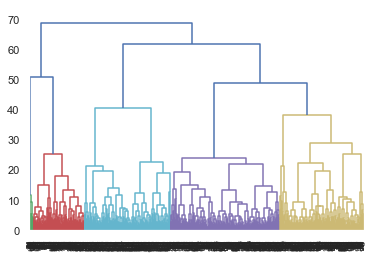

In [26]:
cols = list(rw_scaled.columns)[:-1]
dendrogram = sch.dendrogram(sch.linkage(rw_scaled[cols], method='ward'))
hc = AgglomerativeClustering(n_clusters=7, affinity = 'euclidean', linkage = 'complete') # Here as use "complete" linkage
hc.fit(rw_scaled[cols])
hc.labels_

**Notes:** This dendrogram was made using agglomerative clustering, which means it starts by treating each observation as a separate cluster. Then, it repeatedly executes the following two steps: (1) identify the two clusters that are closest together, and (2) merge the two most similar clusters. Here is more information about this process: https://www.displayr.com/what-is-hierarchical-clustering/

This process recommends 5 clusters. Not the 7 or 8 that I had identified as best from my kmeans clustering method.

## Divisive Clustering with Dendrogram (Top-Down)

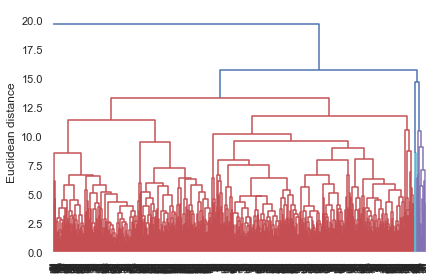

In [29]:
from scipy.cluster.hierarchy import dendrogram
row_clusters = linkage(pdist(rw_scaled, metric='euclidean'), method='complete')
row_dendr = dendrogram(row_clusters)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

**Note:** In contrast, divisive clustering initially assumes all data are in the *same* cluster. The largest cluster is split until every object is separate. We weren't asked to do this for HW, but I wanted to model it here for you for comparison's sake.

## Agglomerative Clustering

**Note:** Below, I run an agglomeratic clustering analysis using k=5, which was recommended by the agglomerative clustering dendrogram (above). This is not what was asked of you for HW. I'm just modeling it here for you to compare the dendrogram's analysis to the kmeans' analysis.

In [30]:
X = pd.DataFrame(rw_scaled, index=rw_scaled.index, columns=rw_scaled.columns)
ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
ac.fit(X)
X['cluster'] = ac.labels_
display(X.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,0.526669,-0.178744,0.445358,-0.044512,0.162541,0.035841,0.172262,0.441592,-0.511431,0.106693,-0.301930,-0.077766
1,-0.643266,0.260418,-0.602720,-0.191917,-0.236612,-0.158858,-0.344182,-0.580945,0.678471,-0.136479,0.387154,0.102642
2,-0.336849,-0.142228,0.274565,4.637286,0.196127,1.459705,1.447095,1.078866,-0.028810,-0.030057,-0.417902,-0.340525
3,0.074897,-0.350945,3.127368,0.043416,11.116408,0.394484,0.320274,0.770280,-2.663717,5.735193,-0.960246,-1.407158
4,-0.481353,-1.552038,0.853943,0.240135,-0.782778,2.189735,2.999027,-2.404984,-1.238276,-0.879637,1.301101,1.126487


**Note:** My threshold = 1.0. Cluster 4 ('quality'=1.13) = high quality. Cluster 3 ('quality'=-1.41) = low quality.

**Note:** If we use aglomerative clustering to generate 5 clusters (as the algomerative dendrogram suggests), then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **free sulfur dioxide, total sulfur dioxide, alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **fixed acidity, density, pH**

* Variables with a strong positive relationship with Low Quality Wine: **citric acid, chlorides, free sulfur dioxide,  sulphates**

* Variables with a strong inverse relationship with Low Quality Wine: **pH**

**Note:** There is still overlapping / ambiguous indicators. If I had to use 5 clusters, then I would either raise my threshold or remove overlapping / ambigous data. Here, I remove overlapping / ambiguous data:

* Variables with a strong positive relationship with High Quality Wine: **total sulfur dioxide, alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **fixed acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **citric acid, chlorides,  sulphates**

* Variables with a strong inverse relationship with Low Quality Wine: 

**Note:** Below, I run an agglomeratic clustering analysis using k=7, which I am supposed to do since that is the same number of clusters that I ran for the kmeans analysis.

In [31]:
X = pd.DataFrame(rw_scaled, index=rw_scaled.index, columns=rw_scaled.columns)
ac = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='complete')
ac.fit(X)
X['cluster'] = ac.labels_
display(X.groupby('cluster').mean())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
cluster,,,,,,,,,,,,
0,0.050707,0.036433,0.743626,-0.371068,4.501466,-0.278706,0.201839,0.258398,-1.185418,2.388530,-0.846617,-0.135891
1,-0.699816,0.769129,-0.971393,-0.144818,-0.138106,-0.345528,-0.391790,-0.180082,0.798626,-0.390118,-0.256283,-0.447350
2,-0.336849,-0.142228,0.274565,4.637286,0.196127,1.459705,1.447095,1.078866,-0.028810,-0.030057,-0.417902,-0.340525
3,0.074897,-0.350945,3.127368,0.043416,11.116408,0.394484,0.320274,0.770280,-2.663717,5.735193,-0.960246,-1.407158
4,-0.481353,-1.552038,0.853943,0.240135,-0.782778,2.189735,2.999027,-2.404984,-1.238276,-0.879637,1.301101,1.126487
5,0.457167,-0.244662,0.412115,-0.044071,-0.064022,0.081653,0.153819,0.366500,-0.396605,0.067302,-0.200105,0.006924
6,-0.646247,-0.224986,-0.287922,-0.282040,-0.378347,-0.046229,-0.400648,-1.374525,0.585091,-0.019974,1.492552,0.813101


**Note:** My threshold = 1.0. Cluster 4 ('quality'=1.13) = high quality. Cluster 3 ('quality'=-1.41) = low quality.

**2a. & 2b. Answer:** If we use aglomerative clustering to generate 7 clusters (the same number of clusters used for our kmeans analysis (above)), then the following variables cluster with high and low wine quality:

* Variables with a strong positive relationship with High Quality Wine: **free sulfur dioxide, total sulfur dioxide, alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **volatile acidity, density, pH**

* Variables with a strong positive relationship with Low Quality Wine: **citric acid, chlorides, sulphates**

* Variables with a strong inverse relationship with Low Quality Wine: **pH**

**Note:** There is still overlapping / ambiguous indicators after using agglomerative clustering with 7 clusters. If I had to use 7 clusters, then I would either raise my threshold or remove overlapping / ambigous data. Here, I remove overlapping / ambiguous data:

* Variables with a strong positive relationship with High Quality Wine: **free sulfur dioxide, total sulfur dioxide, alcohol**

* Variables with a strong inverse relationship with High Quality Wine: **volatile acidity, density**

* Variables with a strong positive relationship with Low Quality Wine: **citric acid, chlorides, sulphates**

* Variables with a strong inverse relationship with Low Quality Wine:

**Note:** With these adjustments to the final analysis, it appears that agglomerative clustering with 7 clusters produces very similar results to kmeans clustering with 5 clusters. They also agree with the kmeans cluster analysis that alcohol may be an indicator of high quality and volitile acidity may be an indicator of low quality.

**2c. Answer:** Therefore, using 7 clusters with agglomerative cluster analysis, I conclude that if you want to make a good bottle of wine, you would want to include high levels of alchohol, free sulfur dioxide and total sulfur dioxide. You would also want to decrease the amount of citric acid, chlorides, and sulphates.

#  Principal Component Analysis

### Question 3:

#### Use Principal Components Analysis to reduce the dimensions of your data. 

#### 3a. How much of the variation in your data is explained by the first two principal components?

#### 3b. How might you use the first two components to do supervised learning on some other variable tied to wine (e.g. - wine price)?

In [32]:
# Remove 'cluster' column from data
# Adjust variable type to values
rw = rw_scaled.loc[:, rw_scaled.columns != 'cluster'].values

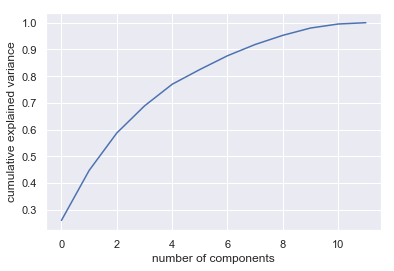

In [33]:
pca = PCA().fit(rw.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

**Note:** Notice that it looks like the first 2 principle components (PCs) don't actually explain very much of the variance. So, I'm expecting the cumulative variance explained by the first to PCs to be rather low.

In [34]:
pca = PCA(0.75).fit(rw.data)
print(pca.n_components_) 

pca = PCA(0.85).fit(rw.data)
print(pca.n_components_) 

pca = PCA(0.95).fit(rw.data)
print(pca.n_components_) 

5
7
9


**Note:** Notice that if I wanted to explain at least 75% of the variance in the data, then I should include 5 PCs. To explain 85% of the variance, I would need 7 PCs. To explain 95%, which is recommended for most PCA, then I would need 9 PCs. (This is not looking good for my first two PCs!)

In [35]:
pca = PCA(n_components=2).fit(rw) 
PC1, PC2 = pca.explained_variance_ratio_
PCs = PC1 + PC2
print("Portion of Explained Variance from the first 2 principal components: {:.2f}".format(PCs))

Portion of Explained Variance from the first 2 principal components: 0.45


**3a. Answer:** Only 45% of the variance is explained by the first to PCs.

Text(0, 0.5, 'Principal components')

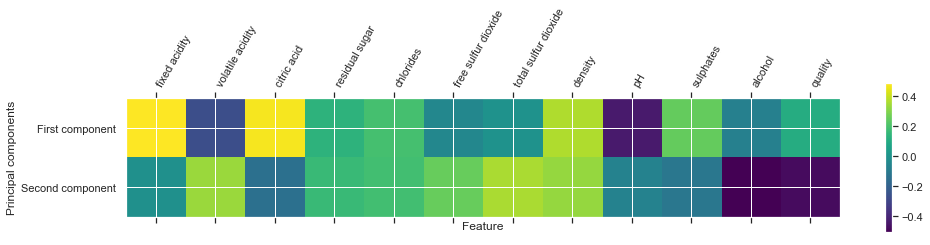

In [36]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(rw_scaled.columns[0:12])),
           rw_scaled.columns[0:12], rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

**Note:** This heatmap shows how much each variable explains the variance for each PC. 

Notice that the first component (PC1) shows that moderately high levels of 'quality' are associated with relatively low levels of 'volitile acidity', which was predicted by both our kmeans analysis and our agglomerative clustering analysis.

Also, notice that for the second component (PC2) 'alcohol' and 'qualty' have the same relationship. Our kmeans analysis and agglomerative analysis also predicted this. Both analyses suggested that alcohol and quality were positively associated. 

**3b. Answer:** There are a variety of ways to answer this question. Two examples are given below. Whatever your answer, the goal is to (a) name a supervised learning method, (b) identify another variable (not already mentioned) that is somehow related to wine, and (c) explain how you would use PC1 and PC2 as training data.

Here are two example answers:

* It looks like the first two components may be distinct in terms of 'citric acid'. PC1 shows high levels of 'citric acid', while PC2 shows relatively low levels of 'citric acid'. So, we could use the first two components to train a classification model (e.g. Logistic Regression, Penalized Logistic Regression, or KNNRegressor) to distinguish between wines that have high and low levels of citric acid. 


* It looks like the first two components have similar values for 'residual sugar'. So, we could combine PC1 and PC2 to create training data for a regression model (Ridge or LASSO) that can identify features / coefficients that are indicators of sweet wines (i.e. wines with moderately high levels of residual sugar).

**Note:** There are many other types of answers that would answer this question. These are just to examples.